# 1. Error Analysis Conclusions & work plan
The analysis points to several issues in the model, particularly with the inflated coefficients for categorical features like phone_brand and os_main. This, combined with the residual analysis, highlights problems with how the linear regression model interprets the data.

**Issues to deal with:**
* The model struggles with high-priced phones, likely due to the lack of sufficient features capturing the specific characteristics of premium devices.

* A higher average magnitude of underestimation compared to overestimation suggests systemic bias in the model, potentially caused by missing interactions or non-linear relationships.

* Extremely large coefficients for categorical features, indicate multicollinearity or a lack of regularization, which distorts the model's predictions.

* Continuous variables like storage, ram, and year have more reasonable coefficients, suggesting these are meaningful predictors

* High-priced phones likely behave as outliers. Without handling them, they exert undue influence on the model.

**solutions:**
* Using regularization techniques like Ridge regression to constrain extreme coefficients.

* Grouping phone_brand categories into broader groups (e.g., premium, mid-range, budget brands).

* Avoiding scaling binary or categorical indicators (nfc, foldable). Ensure only continuous variables are standardized.

* Remove redundant or weak features like colors_available if they contribute minimal predictive value.

* Applying a log transformation to price_usd to stabilize variance and reduce the impact of extreme values.

* Adjusting model complexity to balance bias and variance, by Using cross-validation to evaluate model performance on different splits.





# 2. Improving Model Performance


First we need to upload the data like we did in the previous exercise, and the relevant libraries:

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

dtf = pd.read_csv("/content/data/processed_data2.csv")

**The Baseline Model:**

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np


data = pd.read_csv("/content/data/processed_data2.csv")
data['cpu_core'] = data['cpu_core'].fillna('Unknown')
data['gpu_company'] = data['gpu_company'].fillna('Unknown')
data['os_main'] = data['os'].str.split(',').str[0]
data['os_main'] = data['os_main'].str.lower().apply(
    lambda x: 'ios' if 'ios' in x else ('android' if 'android' in x else 'other')
)
data = data.drop(columns=['os'], errors='ignore')
selected_columns1 = [
    'storage', 'ram', 'foldable', 'ppi_density', 'quantile_90',
    'quantile_50', 'weight', 'quantile_10', 'display_size', 'colors_available',
    'nfc', 'battery', 'year', 'phone_brand', 'os_main'
]
dtf_baseline = data[selected_columns1 + ['price_usd']]
if 'year' in dtf_baseline.columns:
    dtf_baseline.loc[:, 'year'] = pd.to_datetime(dtf_baseline['year'], errors='coerce').dt.year
one_hot_columns = ['phone_brand', 'os_main']
dtf_baseline = pd.get_dummies(dtf_baseline, columns=one_hot_columns, drop_first=True)
X_baseline = dtf_baseline.drop(columns=['price_usd'], errors='ignore')
y_baseline = dtf_baseline['price_usd']
X_baseline = X_baseline.apply(pd.to_numeric, errors='coerce')
scaler_baseline = StandardScaler()
X_baseline = pd.DataFrame(scaler_baseline.fit_transform(X_baseline), columns=X_baseline.columns)
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=42
)
model_baseline = LinearRegression()
model_baseline.fit(X_train_baseline, y_train_baseline)


LinearRegression()

* Ensure that all missing values are imputed properly to avoid bias:

  * Numeric Features: Use the median for robust imputation
  * Categorical Features: Replace missing values with a placeholder like 'Unknown'

In [37]:
dtf = pd.read_csv("/content/data/processed_data2.csv")
numerical_cols = ['ppi_density', 'battery', 'storage', 'ram', 'weight']
dtf[numerical_cols] = dtf[numerical_cols].fillna(dtf[numerical_cols].median())
dtf['cpu_core'] = dtf['cpu_core'].fillna('Unknown')
dtf['gpu_company'] = dtf['gpu_company'].fillna('Unknown')

* Feature Engineering:

 New features are created:
 * price_per_gb: Price per gigabyte of storage.
 * battery_per_weight: Battery capacity divided by weight.
 * log_price_usd: The logarithm of price_usd to normalize the distribution.
 * os_main: Extracting the primary operating system from the os column.
 The os_main column is normalized to lowercase and categorized into three categories: ios, android, or other.

In [38]:
dtf['price_per_gb'] = dtf['price_usd'] / dtf['storage']
dtf['battery_per_weight'] = dtf['battery'] / dtf['weight']
dtf['log_price_usd'] = np.log1p(dtf['price_usd'])
dtf['os_main'] = dtf['os'].str.split(',').str[0]
dtf['os_main'] = dtf['os_main'].str.lower().apply(
    lambda x: 'ios' if 'ios' in x else ('android' if 'android' in x else 'other')
)
dtf = dtf.drop(columns=['os', 'price_usd'], errors='ignore')

* Manual Target Encoding:
  * The phone_brand is encoded by calculating the mean of log_price_usd for each brand, which helps in using a numerical representation of categorical data.
  
  * Similarly, the cpu_core and gpu_company columns are encoded based on their relationship with log_price_usd.



In [39]:

phone_brand_mean = dtf.groupby('phone_brand')['log_price_usd'].mean()
dtf['phone_brand_encoded'] = dtf['phone_brand'].map(phone_brand_mean)
dtf = dtf.drop(columns=['phone_brand'], errors='ignore')

cpu_core_mean = dtf.groupby('cpu_core')['log_price_usd'].mean()
dtf['cpu_core_encoded'] = dtf['cpu_core'].map(cpu_core_mean)
gpu_company_mean = dtf.groupby('gpu_company')['log_price_usd'].mean()
dtf['gpu_company_encoded'] = dtf['gpu_company'].map(gpu_company_mean)
dtf = dtf.drop(columns=['cpu_core', 'gpu_company'], errors='ignore')

* Selecting Features:

  A set of features is selected based on domain knowledge, and the target variable log_price_usd is added





In [40]:
selected_columns = [
    'storage', 'ram', 'foldable', 'ppi_density', 'quantile_90',
    'quantile_50', 'weight', 'quantile_10', 'display_size',
    'price_per_gb', 'battery_per_weight', 'nfc', 'battery', 'year',
    'phone_brand_encoded', 'cpu_core_encoded', 'gpu_company_encoded', 'os_main'
]
dtf = dtf[selected_columns + ['log_price_usd']]

* One-Hot Encoding for 'os_main':

  os_main is one-hot encoded (turning the ios and android columns into binary indicators, dropping one to avoid multicollinearity).

In [41]:
dtf = pd.get_dummies(dtf, columns=['os_main'], drop_first=True)

* Preparing Features and Target:

In [42]:
# Splitting features and target
X = dtf.drop(columns=['log_price_usd'], errors='ignore')
y = dtf['log_price_usd']

# Handling missing values in features
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.median(), inplace=True)

# Checking for any remaining NaN values
dt_missing = X.isnull().sum().sum()
if dt_missing > 0:
    print(f"Warning: {dt_missing} missing values detected and filled with 0.")
    X.fillna(0, inplace=True)

# Standardizing features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid = GridSearchCV(Ridge(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})

# 3. Analyzing the Improved Model


* **Feature Importance:**

 We'll calculate and visualize feature importance using SHAP (SHapley Additive exPlanations) and permutation importance to understand the contribution of each feature to the predictions.

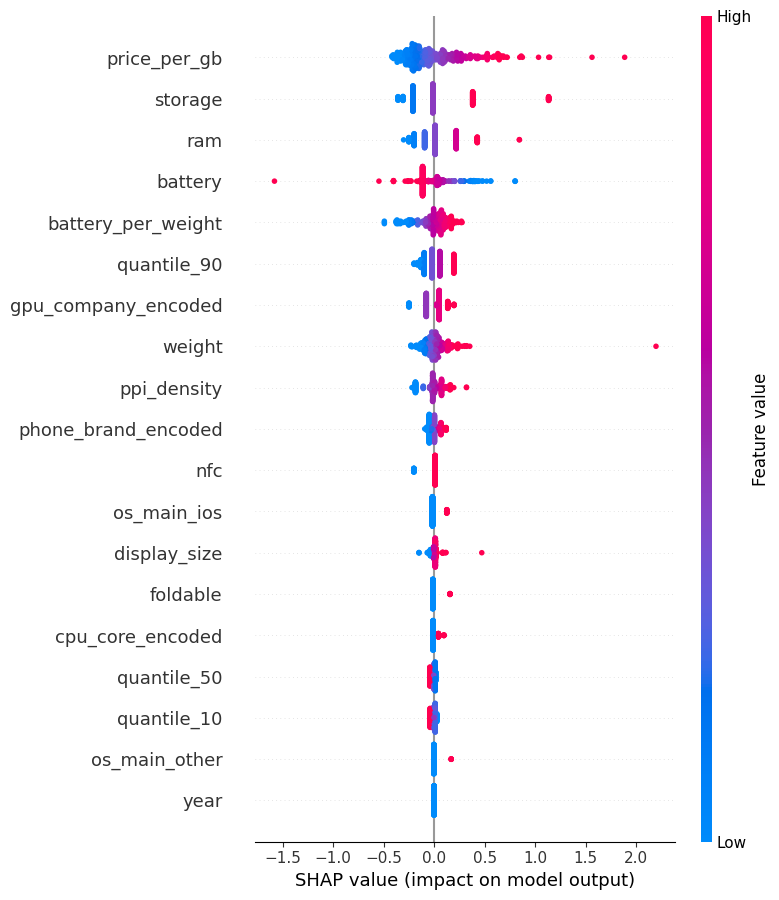

In [43]:
import shap
explainer = shap.LinearExplainer(grid.best_estimator_, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


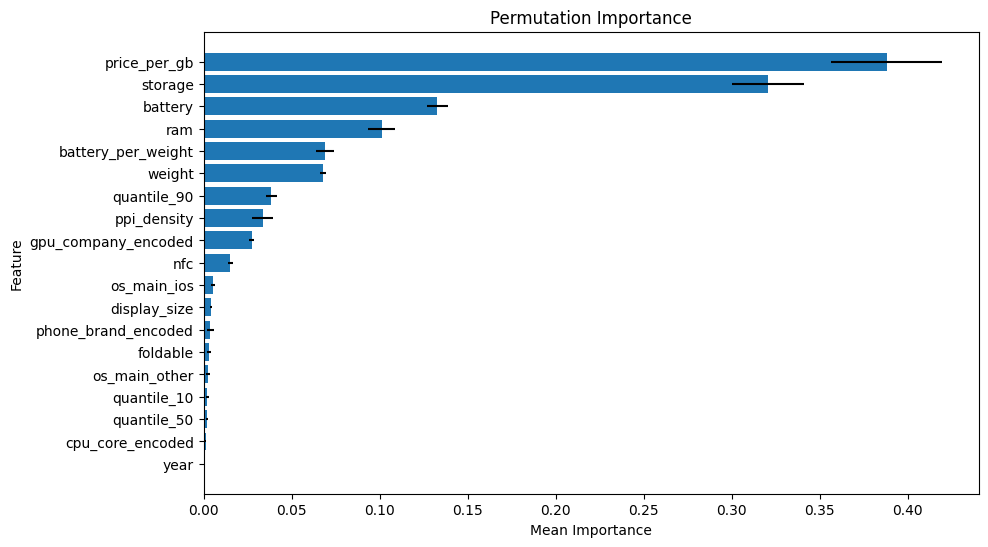

In [44]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(grid.best_estimator_, X_test, y_test, scoring='r2')
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'], perm_df['Importance'], xerr=perm_df['Std'])
plt.gca().invert_yaxis()
plt.title('Permutation Importance')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()


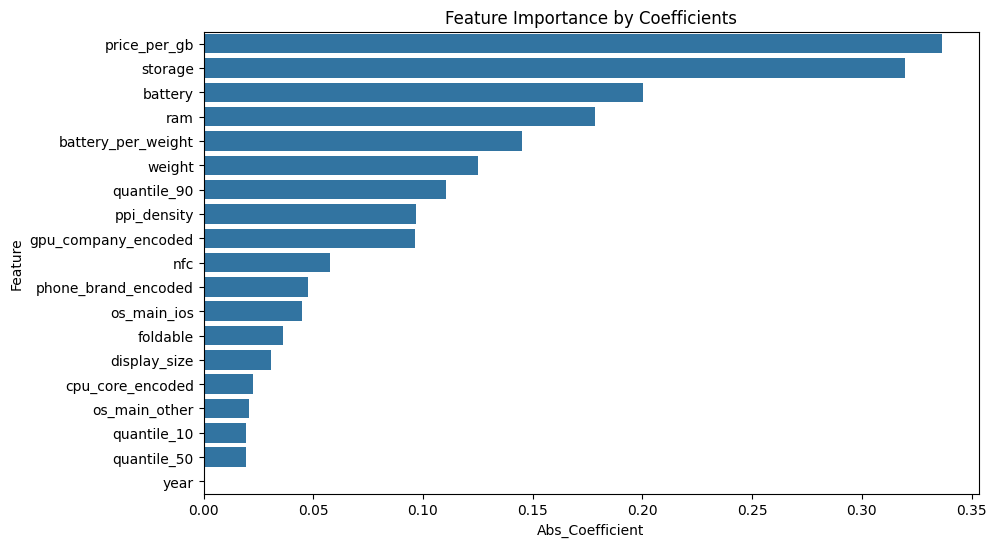

In [45]:
coefficients = grid.best_estimator_.coef_
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=coeff_df)
plt.title('Feature Importance by Coefficients')
plt.show()


* **Compare Baseline vs Improved Model**

 We'll compute metrics for both models and compare them:

 * R² (coefficient of determination).
 * RMSE (Root Mean Squared Error).
 * MAE (Mean Absolute Error).
 * Pearson Correlation (to assess the linear correlation between true and predicted values).

Code to Compare Model Performance:

In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

y_baseline_pred = model_baseline.predict(X_test_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test_baseline, y_baseline_pred))
baseline_mae = mean_absolute_error(y_test_baseline, y_baseline_pred)
baseline_r2 = r2_score(y_test_baseline, y_baseline_pred)
baseline_corr, _ = pearsonr(y_test_baseline, y_baseline_pred)
y_improved_pred = grid.predict(X_test)
improved_rmse = np.sqrt(mean_squared_error(y_test, y_improved_pred))
improved_mae = mean_absolute_error(y_test, y_improved_pred)
improved_r2 = r2_score(y_test, y_improved_pred)
improved_corr, _ = pearsonr(y_test, y_improved_pred)
print("Baseline Model:")
print(f"R²: {baseline_r2:.3f}, RMSE: {baseline_rmse:.3f}, MAE: {baseline_mae:.3f}, Pearson Correlation: {baseline_corr:.3f}")
print("\nImproved Model:")
print(f"R²: {improved_r2:.3f}, RMSE: {improved_rmse:.3f}, MAE: {improved_mae:.3f}, Pearson Correlation: {improved_corr:.3f}")


Baseline Model:
R²: 0.649, RMSE: 224.762, MAE: 158.985, Pearson Correlation: 0.806

Improved Model:
R²: 0.883, RMSE: 0.270, MAE: 0.211, Pearson Correlation: 0.940


* **Visualization**

Visualizations will include:

* Comparison of Metrics: A bar chart comparing R², RMSE, and MAE for both models.

* Residual Plot: Scatter plot of residuals (errors) to check for patterns and improvement in predictions.
* Actual vs Predicted Values: A scatter plot to visualize the relationship.

 Plot of Actual vs. Predicted Values:

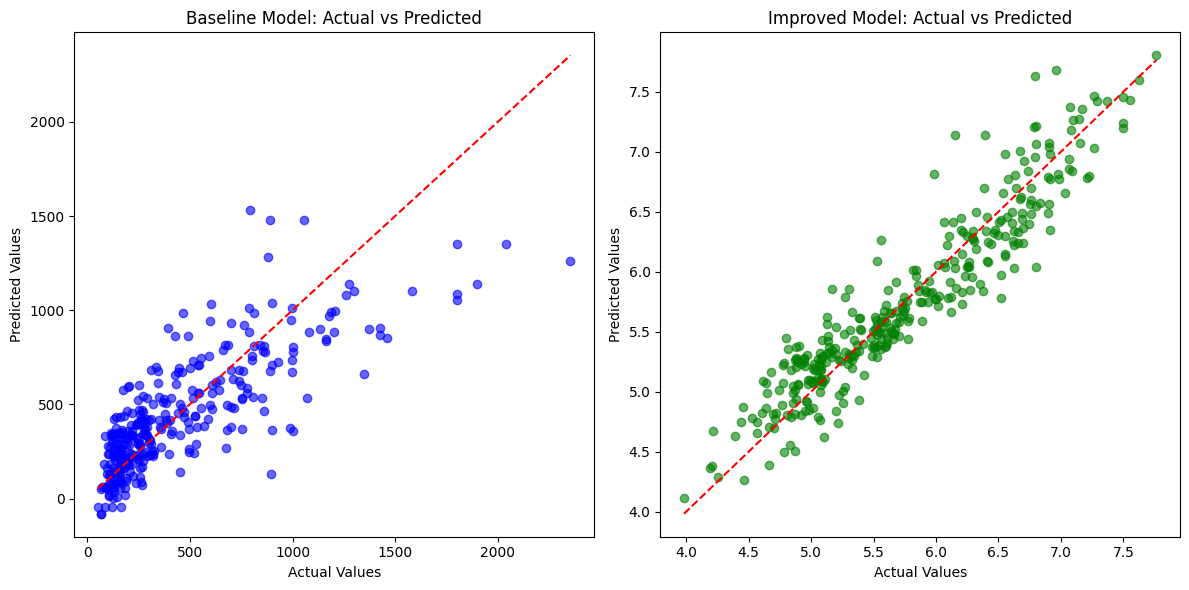

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_baseline, y_baseline_pred, color='blue', alpha=0.6, label='Baseline')
plt.plot([min(y_test_baseline), max(y_test_baseline)], [min(y_test_baseline), max(y_test_baseline)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Baseline Model: Actual vs Predicted')


plt.subplot(1, 2, 2)
plt.scatter(y_test, y_improved_pred, color='green', alpha=0.6, label='Improved')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Improved Model: Actual vs Predicted')

plt.tight_layout()
plt.show()


Plot of Residuals

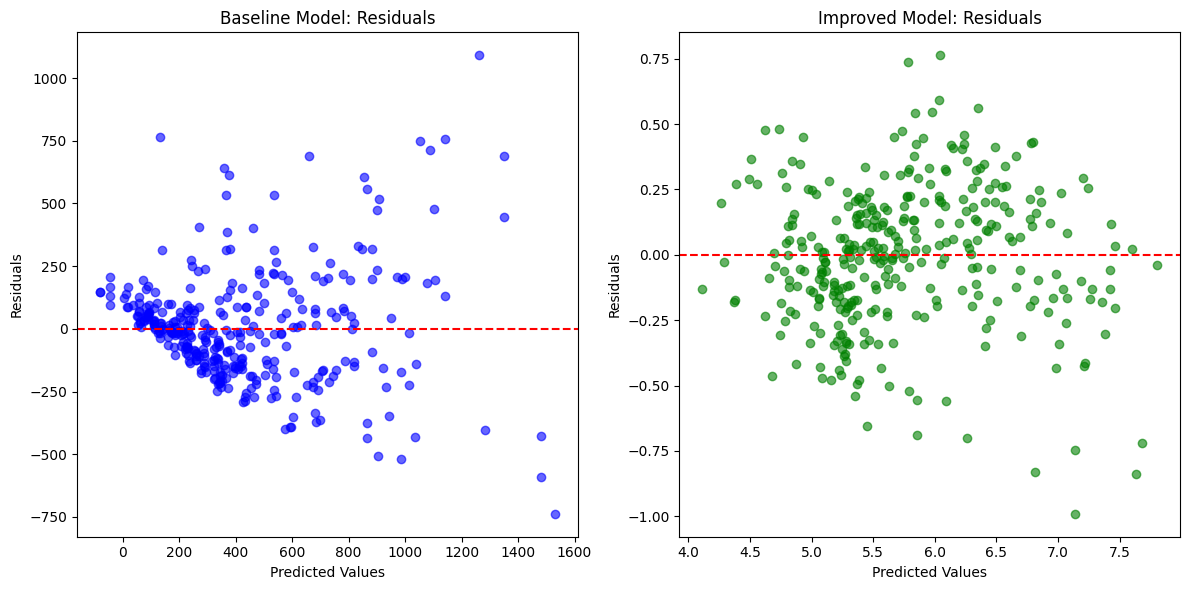

In [48]:
residuals_baseline = y_test_baseline - y_baseline_pred
residuals_improved = y_test - y_improved_pred

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_baseline_pred, residuals_baseline, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Baseline Model: Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_improved_pred, residuals_improved, color='green', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Improved Model: Residuals')

plt.tight_layout()
plt.show()


Feature Importance (Improved Model):

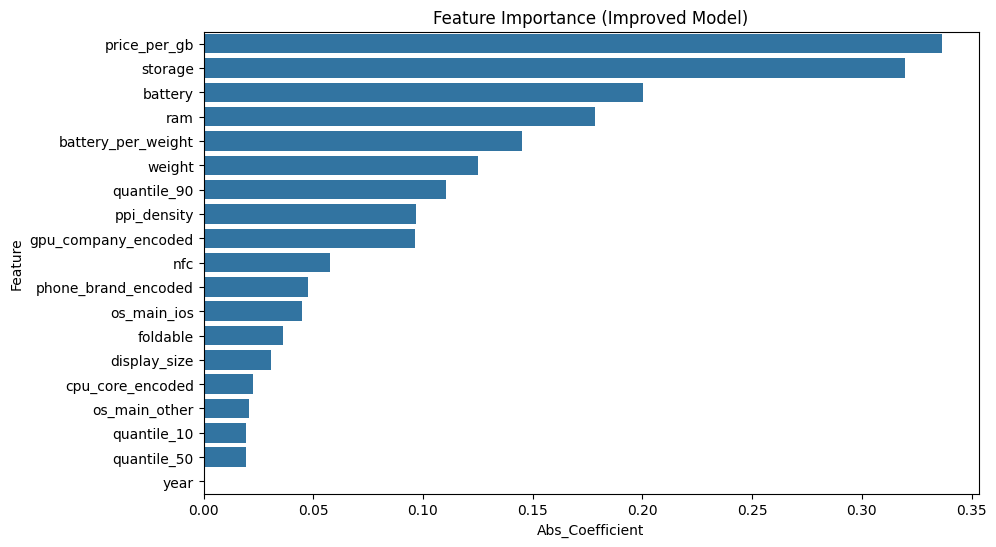

In [49]:
import seaborn as sns
coefficients = grid.best_estimator_.coef_
feature_names = X.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance (Improved Model)')
plt.show()


# 4. Drawing Conclusions About the Data & Creative Applications

*  **Which features are most influential?**

 * **Price per GB:**

     **Interpretation:**
     This feature, derived from dividing the phone's price by its storage capacity, serves as a strong indicator of value. It reflects how efficiently a phone's price scales with its storage, making it a critical factor for pricing trends.

     **Reason for Importance:** Storage upgrades often come with significant price increases, especially in premium phones.

 * **Storage:**

     **Interpretation:** The total storage capacity (in GB) is directly tied to the phone's utility and pricing. Higher storage is a key differentiator in models across all price ranges.

    **Reason for Importance:** Consumers prioritize storage for media, apps, and data, making it a vital aspect of purchasing decisions.

 * **Battery:**

     **Interpretation:** The total battery capacity (in mAh) is a critical feature for smartphone usability and endurance. Higher capacities generally appeal to users who prioritize longer battery life.
     **Reason for Importance:** Battery capacity influences customer satisfaction, especially in mid-tier and budget segments.

 * **RAM:**

    **Interpretation:** RAM capacity determines multitasking ability and overall performance. It is a key spec for phones, especially those marketed to tech-savvy consumers.

    **Reason for Importance:** Higher RAM translates to smoother performance, which is closely associated with premium devices.
    
  * **Battery per Weight:**

     **Interpretation:** This derived feature indicates how efficiently a phone combines battery capacity with its weight. A higher ratio implies a lightweight yet long-lasting design.

     **Reason for Importance:** Lightweight phones with good battery life are often premium, emphasizing their importance in pricing.

  * **Weight:**

    **Interpretation:**
      The weight of a phone affects portability and user experience. Heavier phones are often associated with larger batteries and displays.

      **Reason for Importance:** Weight correlates with premium features like large screens and durable materials, impacting both design and usability.

**Are there identifiable patterns or biases (e.g., feature correlation with outcomes)?**

* **Brand:**

  Premium brands show disproportionately higher prices than mid-tier or budget brands, irrespective of technical specs.
  Encoded phone_brand values highlight stark differences in log_price_usd.

* **Price Distributions:**

  Price quantiles reveal clustering in three ranges: low, medium, and high. These clusters align with predefined price_range categories, indicating that segmentation accurately captures market trends.

* **Foldable Devices:**

  Foldable phones have a consistently higher price tag, aligning with their novelty and technological sophistication.

* **Battery and Weight:**

  Phones with a high battery-per-weight ratio are often lightweight and premium, indicating a design-driven trend in high-end devices.

# **Any surprising findings? Are specific features driving predictions more than expected?**

# Surprising Findings:

* Derived Features Outperforming Raw Features:

 Features like Price per GB and Battery per Weight significantly impact predictions. These derived metrics provide deeper insights into value and design trends, surpassing the importance of individual specs like raw storage or battery capacity.

* Weight's Influence:

  While weight might seem secondary, its importance highlights that consumers equate lighter phones with better engineering, especially when paired with strong battery performance. This is more pronounced in premium models.

* RAM's Diminishing Returns:

  Higher RAM consistently influences price, but its impact diminishes beyond certain thresholds (e.g., above 12GB). This suggests other factors like brand or design take precedence in high-end models.

* Operating System (OS) Trends:

 iOS devices are priced significantly higher than Android, even when specs are similar. This reflects brand loyalty and the premium users place on the Apple ecosystem.

* Quantile Pricing Patterns:

 The 90th quantile of prices captures high-end devices' trends accurately, while the 10th quantile highlights budget-friendly options. This division suggests a well-segmented market with clear consumer preferences.


# **Explain findings in a user-friendly narrative to communicate insights effectively:**
The smartphone market is shaped by both traditional specifications and innovative design choices. Key takeaways include:

* Value Matters: Consumers are highly influenced by how much they pay per GB of storage. Phones offering more storage at a better price are perceived as better value.
* Lightweight Premiums: Phones that balance weight and battery capacity are considered more desirable, especially in the premium category.
* Specs Aren't Everything: Beyond a certain point, increasing RAM or storage adds less to the price, signaling that features like design, brand reputation, and software ecosystem drive consumer choices.
* OS Drives Price: Apple’s ecosystem (iOS) commands a higher price, reflecting its value beyond raw specifications.

# **Propose potential applications for the dataset or findings:**
# **1. Real-World Use Cases:**

 **Marketing Campaigns:**

Highlight price per GB and battery-to-weight ratios in ads targeting value-conscious consumers.
Focus on lightweight designs and performance for premium buyers.

**Feature-Based Segmentation:**

Use the quantile analysis to identify price-sensitive segments and tailor marketing strategies.

**Product Differentiation:**

For manufacturers, these insights can guide decisions on which features to emphasize when designing or advertising a new product.




# **2. Predictive Tools for Stakeholders:**

**Price Prediction Tool:**

Develop a tool for retailers to recommend optimal pricing based on features, brand, and market trends.
Predict how much a phone should cost in different regions or stores based on its specs.

**Consumer Decision Aid:**

Build a consumer-facing application to compare smartphones based on derived value metrics like price per GB, battery per weight, and predicted price fairness.

# **3. Further Research Opportunities**

**Trend Analysis in New Features:**

Analyze how newer technologies influence pricing and adoption.

**Region-Based Analysis:**

Explore how regional preferences affect the significance of features like NFC or specific OS types.
# **4. Inspired Ideas from Research and Tools**

**Dynamic Pricing Models:**

Inspired by pricing tools in e-commerce, implement real-time price adjustment mechanisms for retailers.

**Market Basket Analysis:**

Pair this dataset with consumer purchase data to identify complementary features.

**Applications in Credit Scoring:**

Leverage findings on consumer preferences for premium features to predict purchasing power or creditworthiness.